In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [74]:
%store -r lda
# from nltk_coll_topic.ipynb

In [75]:
%store -r doc2vec_final
# from doc2vec.ipynb

In [76]:
%store -r input
# from undersampling.ipynb, a list of vectors obtained by concatenating for each document its doc2vec vector and a vector with the topic modeling probabilities

In [77]:
%store -r df
# from undersampling.ipynb, has the labels after the undersampling

In [78]:
df

,Argument ID,Openness to change,Self-Enhancement,Conservation,Self-Transcendence,labels
0,A01002,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
1,A01005,0,0,1,0,"[0.0, 0.0, 1.0, 0.0]"
2,A01006,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
3,A01007,0,0,2,1,"[0.0, 0.0, 0.6666666666666666, 0.3333333333333..."
4,A01008,0,0,1,2,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666..."
...,...,...,...,...,...,...
5383,E08005,0,1,2,1,"[0.0, 0.25, 0.5, 0.25]"
5384,E08008,0,1,1,1,"[0.0, 0.3333333333333333, 0.3333333333333333, ..."
5385,E08009,0,1,1,0,"[0.0, 0.5, 0.5, 0.0]"
5387,E08016,0,2,1,1,"[0.0, 0.5, 0.25, 0.25]"


We first create the training set

In [79]:
X_train = np.array(input)

In [80]:
train_labels = [row.labels for id, row in df.iterrows()]

In [81]:
# to implement our classification problem (that is multi-class and multi-label) we will use binary crossentropy with a sigmoid activation
# function in the last layer: now we transform pur probabilities labels in "binary" labels.
y_train = []
for label in train_labels:
    new_label = []
    for value in label:
        if value > 0:
            new_label.append(1)
        else:
            new_label.append(0)
    y_train.append(new_label)

In [82]:
# we tranform our y_train in an array
y_train = np.array(y_train)

In [83]:
# since we are using a concatenation of doc2vec vectors and probabilities vectors from lda we decided to normalize our data
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

We now use the doc2vec model and the lda to extract the doc2vec vectors and topic probabilities from validation set

In [85]:
%store -r y_val
# from preprocessing_validation.ipynb

In [86]:
%store -r val_d2v_topic_vec
# from preprocessing_validation.ipynb

In [87]:
X_val = np.array(val_d2v_topic_vec)

In [88]:
X_val = scaler.fit_transform(X_val)

In [89]:
X_val[0]

array([-0.21897328, -0.28956918, -0.31116289, -0.30819973, -0.38598519,
       -0.27756724, -0.32821338, -0.30369839,  1.69369078, -0.34530871,
       -0.27144565, -0.30065987, -0.32871473, -0.26483439, -0.27596003,
        1.61254942, -0.49715226, -0.36106349,  1.38614602,  2.96834166,
        3.72179125,  2.4669081 , -0.63884464, -1.26971152, -3.3444115 ,
        0.37543085,  1.1861427 , -3.37506297,  1.62852762,  3.647419  ,
       -0.30911948,  3.73287083,  2.16085135, -2.32132782, -1.76041378,
       -2.0678935 ,  1.35797982, -1.13300291, -2.06011215,  0.9256196 ,
       -0.41903448, -3.67446507, -3.10673379,  2.52355842,  3.62260193,
        1.47857248, -2.58099106,  3.29712318,  2.01516801, -2.32139452,
       -3.04813632,  3.03705835, -3.33124351,  3.34948654,  2.95999988,
        2.5994671 ,  3.38488704, -3.46029891, -3.27696512,  3.52653181,
       -3.3947618 , -2.65936907,  3.83575005, -3.52311068,  3.82923501,
       -3.10096249,  3.33350972,  1.52269909, -3.29362225,  3.10

In [90]:
# this the features len for the concatenation of doc2vec (200 features) and topic modeling (19 topics)
features_len = 219

In [91]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [92]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [93]:
X_val.shape

(1576, 219)

In [94]:
X_train.shape

(2770, 219)

In [98]:
# reshaping the data to add an extra dimension
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [99]:
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=( 1, features_len)))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.7))

# Output layer with 6 units for classification
model.add(Dense(4, activation='sigmoid'))

# Create an optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.0001)

# Use ReduceLROnPlateau callback to adjust learning rate during training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1)

threshold = 0.5

y_pred_probs = model.predict(X_val)

# convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > threshold).astype(int)

# print classification report
print(classification_report(y_val, y_pred_binary))

# calculate and return accuracy or other primary metric
accuracy = accuracy_score(y_val, y_pred_binary)
# this accuracy is less indicative since it computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
accuracy

Epoch 1/20


87/87 [==============================] - 4s 15ms/step - loss: 0.6527 - accuracy: 0.1325 - val_loss: 0.6682 - val_accuracy: 0.1256
Epoch 2/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6482 - accuracy: 0.1267 - val_loss: 0.6659 - val_accuracy: 0.2373
Epoch 3/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6447 - accuracy: 0.1415 - val_loss: 0.6670 - val_accuracy: 0.2614
Epoch 4/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6386 - accuracy: 0.1065 - val_loss: 0.6659 - val_accuracy: 0.1332
Epoch 5/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6391 - accuracy: 0.1585 - val_loss: 0.6808 - val_accuracy: 0.2354
Epoch 6/20
87/87 [==============================] - 1s 11ms/step - loss: 0.6370 - accuracy: 0.1603 - val_loss: 0.6769 - val_accuracy: 0.2659
Epoch 7/20
87/87 [==============================] - 1s 10ms/step - loss: 0.6355 - accuracy: 0.1968 - val_loss: 0.6725 - val_accuracy: 0.1199
Epoch 8/20


0.10215736040609137

In [100]:
import matplotlib.pyplot as plt

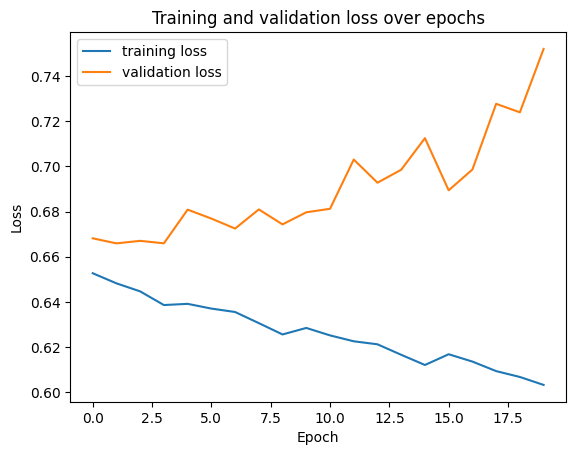

In [101]:
#plot training loss and validation loss
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.show()